### Bike Sharing Demand (kaggle) - Feature Engineering & Modeling
- 자전거 수요(대여횟수)를 예측하는 대회
- 관련 강의 영상 링크 : https://www.youtube.com/watch?v=g7EwIFXJntc&list=PLTlv_RzQG4ZNfrktRlxccWYvwp2BTKYaa&index=3

### Description
* 날짜(datetime) - hourly date + timestamp  
* 계절(season) -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* 휴일여부(holiday) - whether the day is considered a holiday
* 근무일여부(workingday - whether the day is neither a weekend nor holiday
* 날씨(weather) 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* 기온(temp) - temperature in Celsius
* 체감온도(atemp) - "feels like" temperature in Celsius
* 습도(humidity) - relative humidity
* 풍속(windspeed) - wind speed
* 등록 안된사용자가 빌린횟수(casual) - number of non-registered user rentals initiated
* 등록 된사용자가 빌린횟수(registered) - number of registered user rentals initiated

### 최종 목적변수
* (대여횟수)count - number of total rentals  == casual + registered

### 설명
- 분류와 회귀중 회귀와 관련 된 문제
- => 자전거 대여량을 예측하는 문제이기 때문에

### Evaluation
- Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). 

In [93]:
import pandas as pd
import numpy as np
from scipy import stats

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import os
os.chdir('C:/Users/urse/Desktop/dataset/Kaggle_bike_sharing_demand/')
train = pd.read_csv("train.csv", parse_dates=["datetime"])
test = pd.read_csv("test.csv", parse_dates=["datetime"])
print(train.shape, test.shape)
train.head()

(10886, 12) (6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [94]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## Feature Engineering

In [95]:
# year, month, day, hour, minute, second, dayofweek (요일별)
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [96]:
# year, month, day, hour, minute, second, dayofweek (요일별)
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

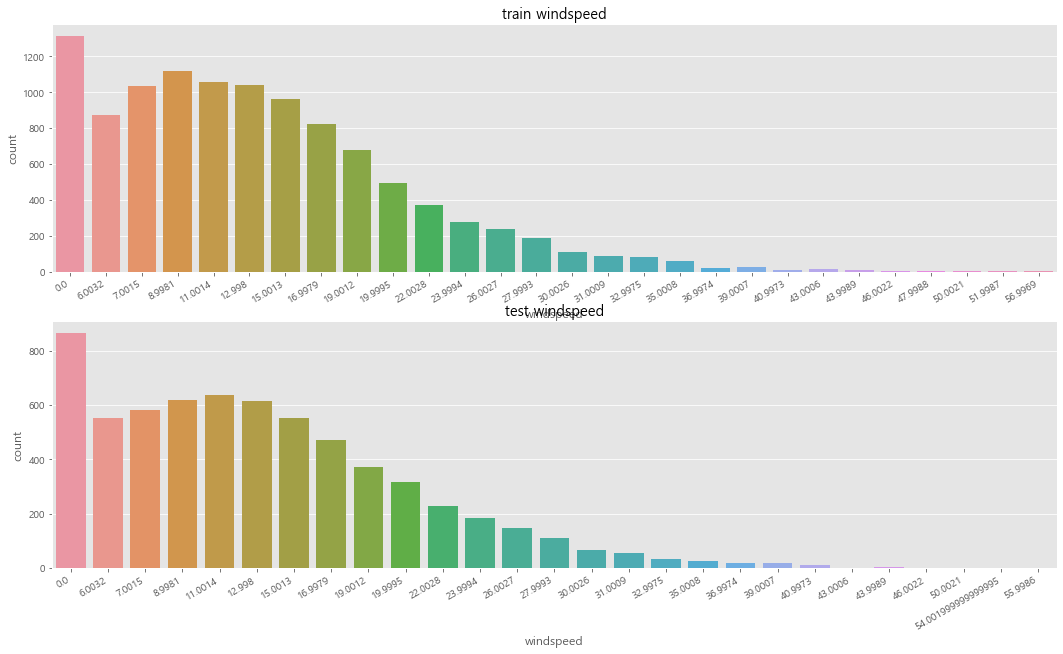

In [97]:
# widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [98]:
# 풍속의 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [99]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [100]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다. (분류 이용 !! -> windspped의 label사용)
from sklearn.ensemble import RandomForestClassifier

# wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    # 풍속이 0이 아닌 것을 train / 0인 것을 test
    dataWind0 = data.loc[data['windspeed'] == 0] # test set
    dataWindNot0 = data.loc[data['windspeed'] != 0] # train set
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터의 windspped를 스트링으로 바꿔준다. 
    # 종속변수값들 (= 정답라벨 = windspeed)
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values # 예측값 넣어주기

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

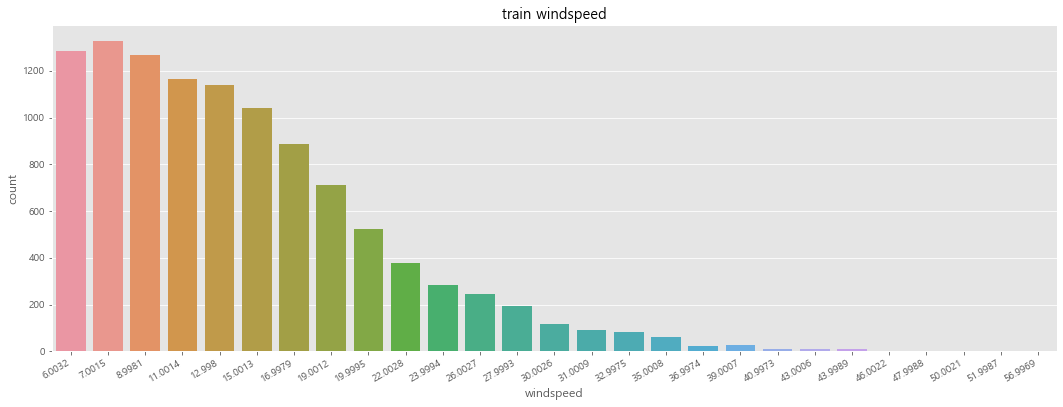

In [101]:
# 0값을 조정한다.
train = predict_windspeed(train)
# test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

## Feature Selection
* 신호와 잡음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [102]:
# 연속형 feature와 범주형 feature 중 범주형 feature 변환

# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다. ==>  좀더 편하게 사용가능.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

### 총 데이터
- 'datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
- 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
- 'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek

### 변수 제거
- 19개 변수중 8개 제외하고 11개 사용

### 제거 데이터 이유
- 'datetime' : 날짜를 넣기 어려우니까 찢어서 사용했고,
- 'casual', 'registered' : testset에는 없으니까
- 'count' : 목적변수
- 'month' : 연도만 넣음.. 근데 year-month 로 보는게 더 맞지 않았을까 싶기도함
- 'day' : day별 특징이 생길테니까 원래는 넣는게 좋으나, 데이터에서 30일이 다 있지 않으니까    
- 'minute', 'second' : 0, 0 이니까 상관x


In [103]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [104]:
X_train = train[feature_names]
X_test = test[feature_names]

label_name = "count"
y_train = train[label_name]

print(X_train.shape, y_train.shape, X_test.shape)

(10886, 11) (10886,) (6493, 11)


# Score
## RMSLE
- 과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.
- 0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

In [105]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

### Cross Validation 교차 검증
* 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다.
![image.png](https://www.researchgate.net/profile/Halil_Bisgin/publication/228403467/figure/fig2/AS:302039595798534@1449023259454/Figure-4-k-fold-cross-validation-scheme-example.png)
이미지 출처 : https://www.researchgate.net/figure/228403467_fig2_Figure-4-k-fold-cross-validation-scheme-example


* KFold 교차검증 
    * 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
    * 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습한다.
    * 나머지 훈련세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
    * 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두 번째 폴드로 정확도를 측정한다.
    * 이 과정을 마지막 폴드까지 반복한다.
    * 이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 정확도가 된다.


## RandomForest

In [106]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# k_fold 객체 생성
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

max_depth_list = []

# model RandomForestRegressor 객체 생성
model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)

%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
#%time score = cross_val_score(model, X_train, y_train, cv=k_fold)

# 5 fold 에 대한 평균 스코어
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

Wall time: 18.5 s
Score= 0.33084


## Train & Test

In [107]:
# 학습
model.fit(X_train, y_train)

# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.81,   5.06,   4.4 ,   3.45,   3.2 ,   6.38,  37.93, 105.65,
       236.2 , 136.58])

[Text(0.5, 1.0, 'test')]

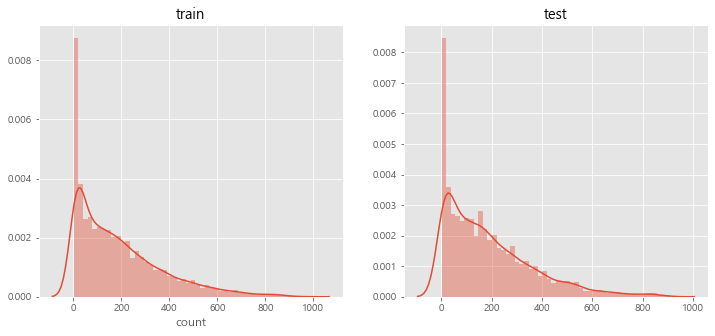

In [108]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

# Submit

In [109]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.81
1,2011-01-20 01:00:00,5.06
2,2011-01-20 02:00:00,4.40
3,2011-01-20 03:00:00,3.45
4,2011-01-20 04:00:00,3.20


In [110]:
submission.to_csv("Score_{0:.5f}_submission.csv".format(score), index=False)
# 상위 12%

참고 : 
* [EDA & Ensemble Model (Top 10 Percentile) | Kaggle](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)
* [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -1)](https://medium.com/@viveksrinivasan/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-1-c816ea9c51e1)
* [How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? (part -2)](https://medium.com/@viveksrinivasan/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-2-29e854aaab7d)